In [1]:
import autograd.numpy as np
from autograd.scipy.special import logsumexp,erf
from autograd.scipy.stats import norm
from autograd import grad

#from autograd_gamma import gamma, gammainc, gammaincc, gammaincln, gammainccln

import matplotlib.pyplot as plt
from copy import deepcopy
from itertools import product
from itertools import combinations
import pickle

from io import StringIO
from Bio import Phylo

from tree import Tree
from optimizer import Optimizer

import warnings
warnings.filterwarnings('ignore')

np.random.seed(0)

/Users/evsi8432/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
pop_size = 0.1 # exponential parameter for constant pop size prior
n_species = 4 # number of species
n_genes = 100 # number of genes

# draw a tree from prior

In [3]:
def draw_log_times_prior(pop_size,n_species):

    # draw coal_times first
    coal_times = []
    for k in range(n_species,1,-1):
        scale_k = 2*pop_size/(k*(k-1))
        coal_times.append(np.random.exponential(scale = scale_k))

    coal_times = np.cumsum(coal_times)

    # now population log_times with coal_time
    log_times = np.zeros((n_species,n_species))
    species = [{i} for i in range(n_species)]
    for coal_time in coal_times:
        species_to_join = np.random.choice(species,2,replace=False)
        for i in species_to_join[0]:
            for j in species_to_join[1]:
                log_times[max(i,j),min(i,j)] = np.log(coal_time)

        new_species = species_to_join[0].union(species_to_join[1])
        species.remove(species_to_join[0])
        species.remove(species_to_join[1])
        species.append(new_species)
        
    log_times[np.triu_indices(n_species)] = max(coal_times)
        
    return log_times

In [4]:
log_times = draw_log_times_prior(pop_size,n_species)

theta = np.zeros((2,n_species,n_species))

theta[0] = log_times
theta[0] = theta[0]*np.tril(np.ones((n_species,n_species)),k=-1)

theta[1] = -1*np.ones((n_species,n_species))
theta[1] = theta[1]*np.tril(np.ones((n_species,n_species)),k=-1)

genomes = ['A']*n_species

nuc2vec = {'A':[1.,0.,0.,0.], 'G':[0.,1.,0.,0.], 'C':[0.,0.,1.,0.], 'T':[0.,0.,0.,1.],
           '-':[1.,1.,1.,1.], '?':[1.,1.,1.,1.], 'N':[1.,1.,1.,1.], 'R':[1.,1.,0.,0.],
           'Y':[0.,0.,1.,1.], 'S':[0.,1.,1.,0.], 'W':[1.,0.,0.,1.], 'K':[0.,1.,0.,1.],
           'M':[1.,0.,1.,0.], 'B':[0.,1.,1.,1.], 'D':[1.,1.,0.,1.], 'H':[1.,0.,1.,1.],
           'V':[1.,1.,1.,0.], '.':[1.,1.,1.,1.], 'U':[0.,0.,0.,1.]}

tree_log_probs = np.array([[nuc2vec[g] for g in genome] for genome in genomes],
                                dtype = float)
tree_log_probs = np.log(tree_log_probs)

In [5]:
real_tree = Tree(theta,log_times,
                 tree_log_probs,
                 pop_size=pop_size)

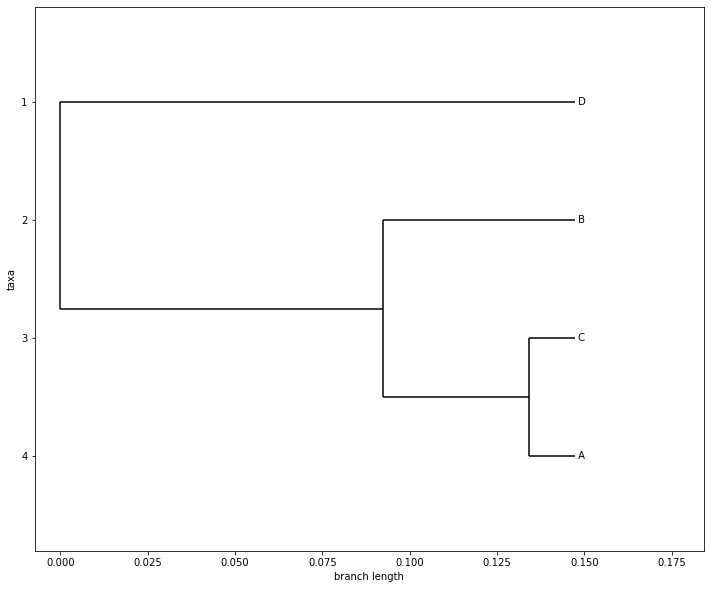

In [6]:
species = ['A','B','C','D']

def write_newick(node):
    
    if node.children == []:
        return species[next(iter(node.leaves))] + ":" + str(node.parent.coal_time)
    elif node.parent is None:
        return "(" + write_newick(node.children[0]) + "," + write_newick(node.children[1]) + ")"
    else:
        bl = node.parent.coal_time - node.coal_time
        return "(" + write_newick(node.children[0]) + "," + write_newick(node.children[1]) + "):" + str(bl)

treedata = write_newick(real_tree.nodes[-1])
handle = StringIO(treedata)
tree_to_draw = Phylo.read(handle, "newick")

# Set up the plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(1, 1, 1)

# Draw the phylogenetic tree
Phylo.draw(tree_to_draw, axes=ax)

# Draw a Genome from the tree

In [7]:
root_genome = [np.random.choice(['A','T','G','C']) for _ in range(n_genes)]
real_tree.nodes[-1].genome = root_genome

In [8]:
def sample_children_genome(node):
    
    if node.children == []:
        return
    
    else:
        # sample genome 1
        bl1 = node.coal_time - node.children[0].coal_time
        q1 = 0.25-0.25*np.exp(-bl1)
        p1 = 0.25+0.75*np.exp(-bl1)
        P1 = {'A':[p1,q1,q1,q1],
              'T':[q1,p1,q1,q1],
              'G':[q1,q1,p1,q1],
              'C':[q1,q1,q1,p1]}
        
        node.children[0].genome = [np.random.choice(['A','T','G','C'],p = P1[g]) for g in node.genome]
        sample_children_genome(node.children[0])
        
        # sample genome 2
        bl2 = node.coal_time - node.children[1].coal_time
        q2 = 0.25-0.25*np.exp(-bl1)
        p2 = 0.25+0.75*np.exp(-bl1)
        P2 = {'A':[p2,q2,q2,q2],
              'T':[q2,p2,q2,q2],
              'G':[q2,q2,p2,q2],
              'C':[q2,q2,q2,p2]}
        
        node.children[1].genome = [np.random.choice(['A','T','G','C'],p = P2[g]) for g in node.genome]
        sample_children_genome(node.children[1])
    
# start recursion
sample_children_genome(real_tree.nodes[-1])
genomes = [leaf.genome for leaf in real_tree.leaves]

In [9]:
for i in range(4):
    for j in range(i):
        print(i,j)
        print(np.mean([x==y for x,y in zip(genomes[i],genomes[j])]))
        print("")

1 0
0.93

2 0
0.98

2 1
0.93

3 0
0.76

3 1
0.75

3 2
0.75



# Run variational inference using the simulated genome

In [10]:
theta

array([[[ 0.        ,  0.        ,  0.        ,  0.        ],
        [-2.89808058,  0.        ,  0.        ,  0.        ],
        [-4.32265832, -2.89808058,  0.        ,  0.        ],
        [-1.91425768, -1.91425768, -1.91425768,  0.        ]],

       [[-0.        , -0.        , -0.        , -0.        ],
        [-1.        , -0.        , -0.        , -0.        ],
        [-1.        , -1.        , -0.        , -0.        ],
        [-1.        , -1.        , -1.        , -0.        ]]])

0.0
0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
final theta: [[[ 0.          0.          0.          0.        ]
  [-2.99836294  0.          0.          0.        ]
  [-4.92727303 -2.93002151  0.          0.        ]
  [-1.5230203  -1.3882478  -1.5174705   0.        ]]

 [[ 0.          0.          0.          0.        ]
  [-1.00523516  0.          0.          0.        ]
  [-0.41702718 -0.79445828  0.          0.        ]
  [-1.28405829 -1.27813544 -1.40752662  0.        ]]]


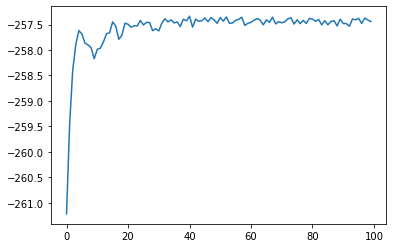

In [11]:
nuc2vec = {'A':[1.,0.,0.,0.], 'G':[0.,1.,0.,0.], 'C':[0.,0.,1.,0.], 'T':[0.,0.,0.,1.],
           '-':[1.,1.,1.,1.], '?':[1.,1.,1.,1.], 'N':[1.,1.,1.,1.], 'R':[1.,1.,0.,0.],
           'Y':[0.,0.,1.,1.], 'S':[0.,1.,1.,0.], 'W':[1.,0.,0.,1.], 'K':[0.,1.,0.,1.],
           'M':[1.,0.,1.,0.], 'B':[0.,1.,1.,1.], 'D':[1.,1.,0.,1.], 'H':[1.,0.,1.,1.],
           'V':[1.,1.,1.,0.], '.':[1.,1.,1.,1.], 'U':[0.,0.,0.,1.]}

tree_log_probs = np.array([[nuc2vec[g] for g in genome] for genome in genomes],dtype = float)
tree_log_probs = np.log(tree_log_probs)

optim = Optimizer(tree_log_probs,theta)

optim.optimize_q_reparam(100,100,alphas=[0.1,0.1],
                         pop_size=pop_size)

print("final theta:",optim.theta)
theta = optim.theta
plt.plot(optim.ELBO_ests)

# draw 10 random trees using a newick file

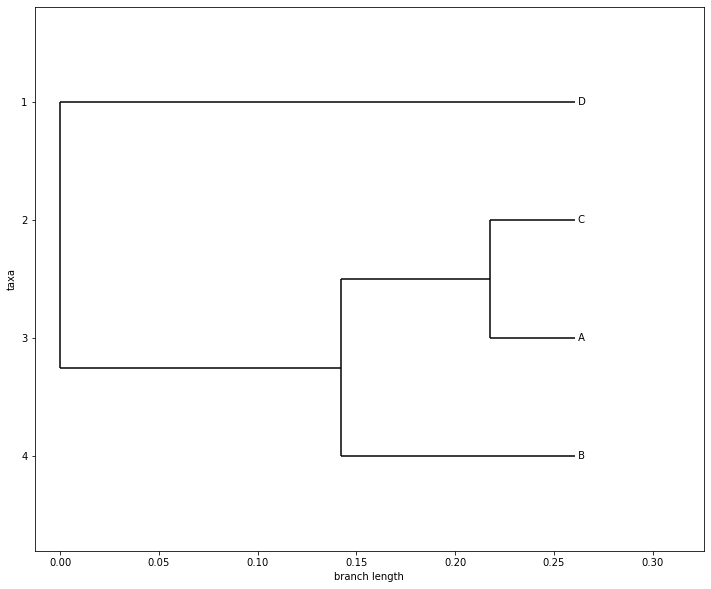

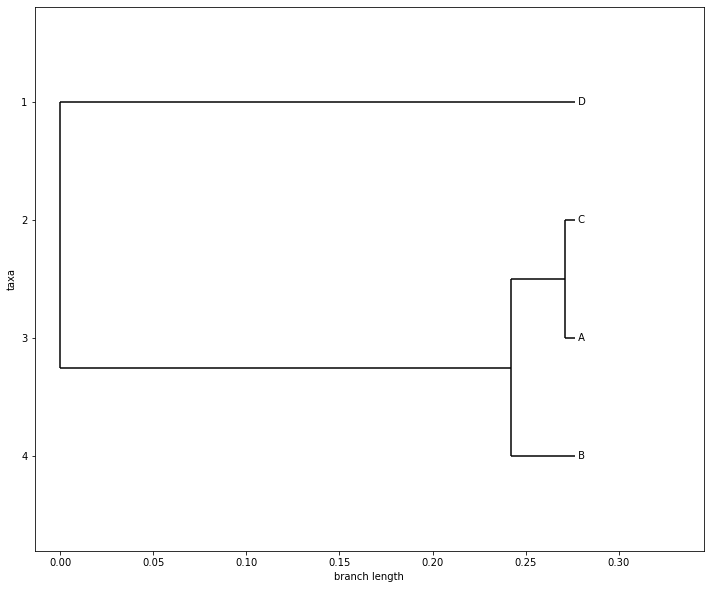

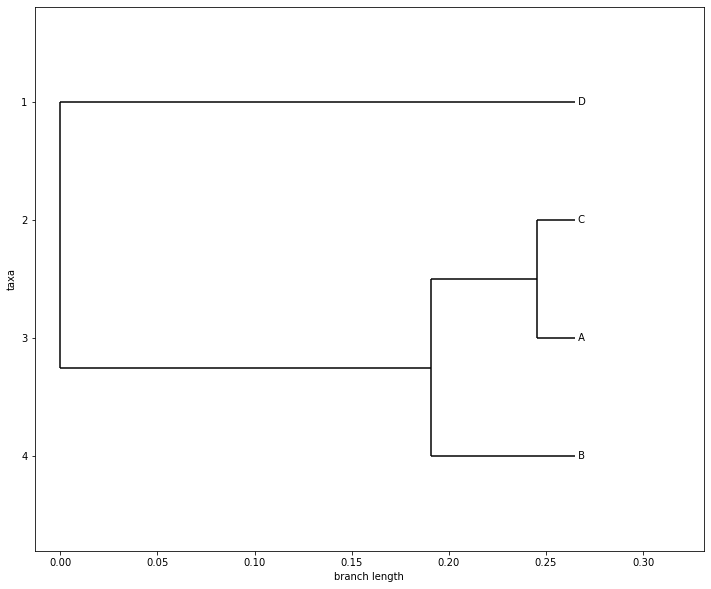

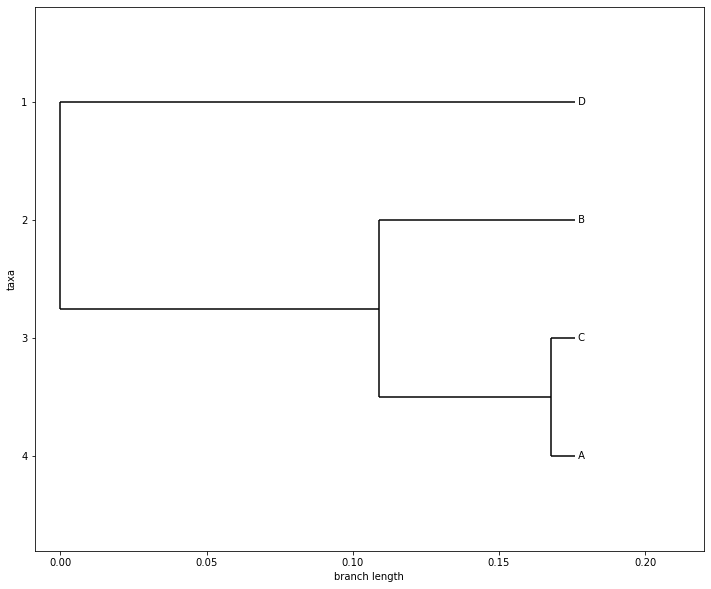

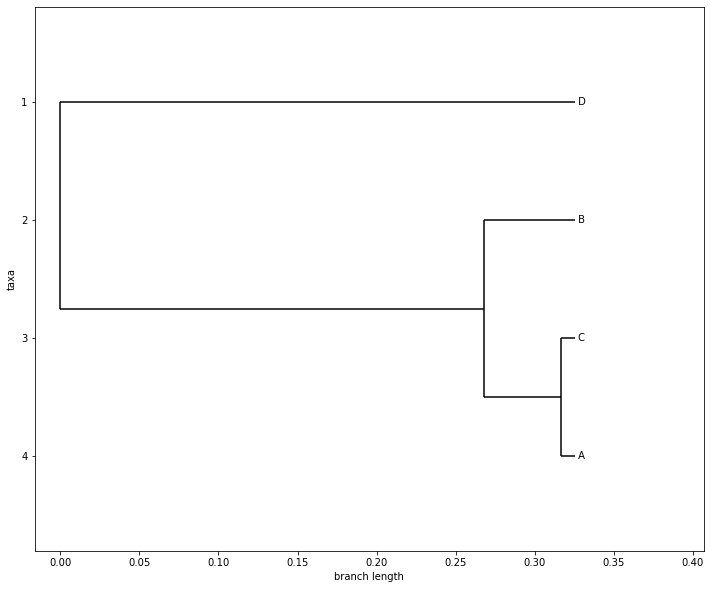

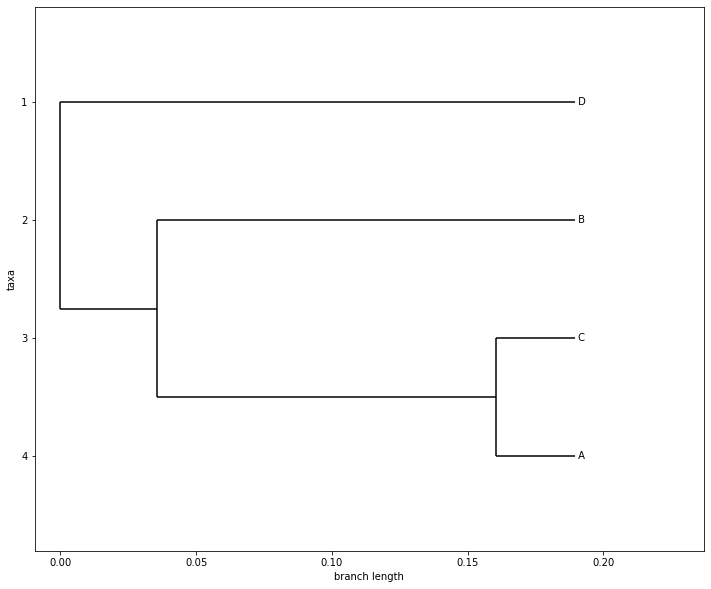

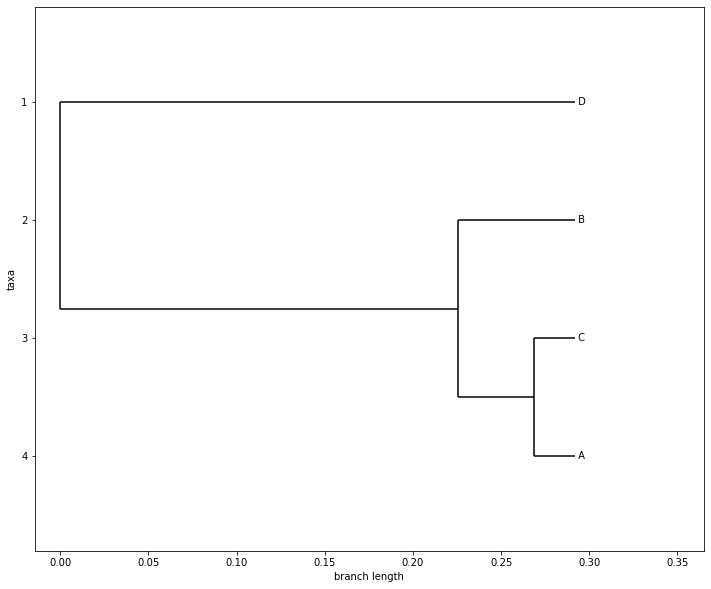

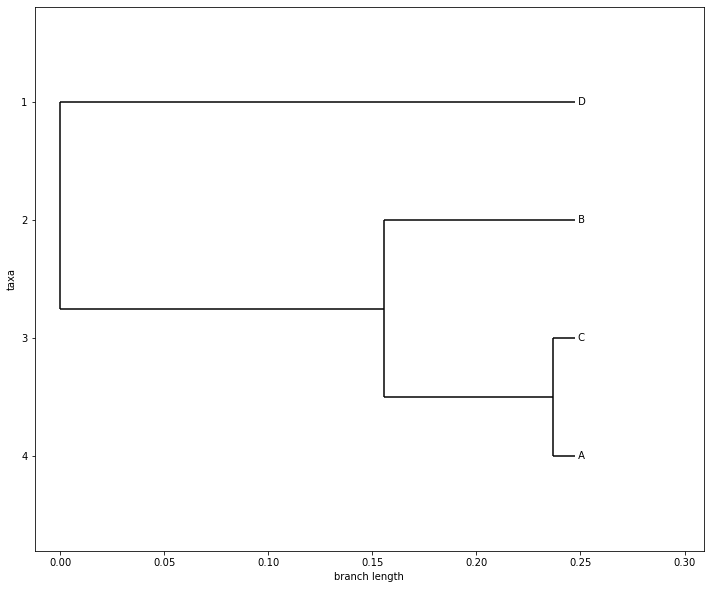

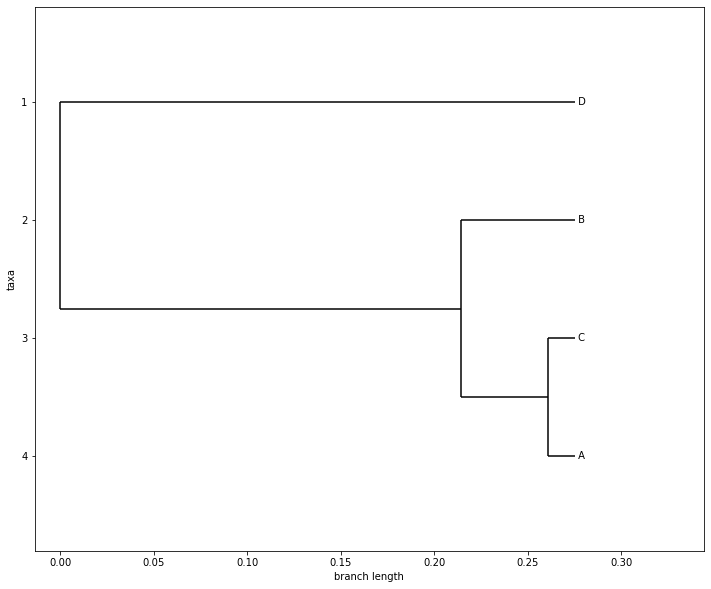

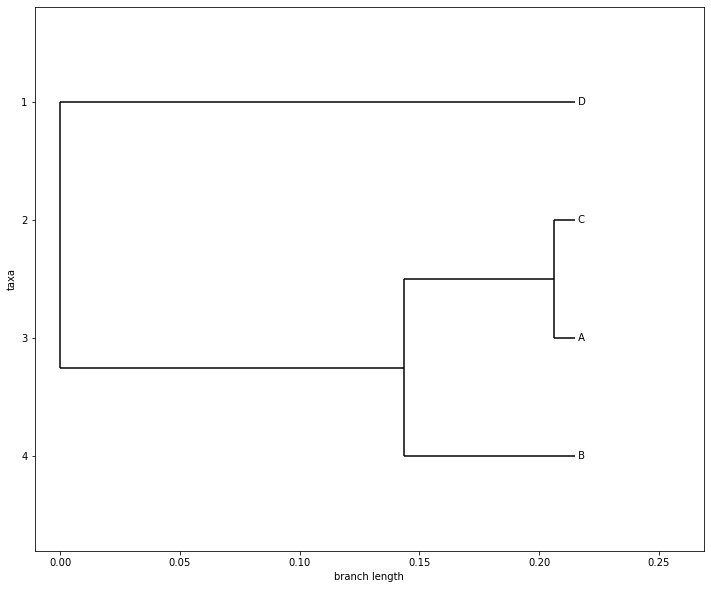

In [12]:
def write_newick(node):
    
    if node.children == []:
        return species[next(iter(node.leaves))] + ":" + str(node.parent.coal_time)
    elif node.parent is None:
        return "(" + write_newick(node.children[0]) + "," + write_newick(node.children[1]) + ")"
    else:
        bl = node.parent.coal_time - node.coal_time
        return "(" + write_newick(node.children[0]) + "," + write_newick(node.children[1]) + "):" + str(bl)

    
for _ in range(10):
    Z = np.random.normal(np.ones_like(theta[0]))
    log_times = np.exp(theta[1])*Z+theta[0]
    log_times = log_times + np.triu(np.ones_like(theta[0])*np.inf)

    tree = Tree(theta,log_times,tree_log_probs,
                pop_size=pop_size)


    treedata = write_newick(tree.nodes[-1])
    handle = StringIO(treedata)
    tree_to_draw = Phylo.read(handle, "newick")

    # Set up the plot
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(1, 1, 1)

    # Draw the phylogenetic tree
    Phylo.draw(tree_to_draw, axes=ax)
    fig.show()

# plot $\theta$

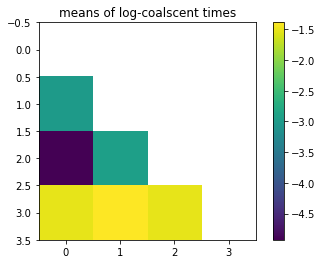

In [13]:
m = deepcopy(theta[0])
m[np.triu_indices(m.shape[0])] = np.nan
plt.imshow(m)
plt.title("means of log-coalscent times")
plt.colorbar()

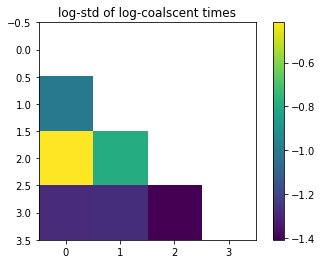

In [14]:
log_sig = deepcopy(theta[1])
log_sig[np.triu_indices(log_sig.shape[0])] = np.nan
plt.imshow(log_sig)
plt.title("log-std of log-coalscent times")
plt.colorbar()